# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-lc'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(torch.sigmoid(outputs[i]).cpu().numpy())
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    # accelerator.print(len(X_pool), len(aspect_outputs))

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    max_pred = np.max(preds[i].cpu().numpy())
                    sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
                else:
                    sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        aspect_outputs = {indices: 1 - prob for indices, prob in aspect_outputs.items()}
        aspect_outputs = dict(sorted(aspect_outputs.items()))
    
        # accelerator.print(aspect_outputs)
        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = ((1 - val) + aspect_outputs[key]) / 2
    
        # accelerator.print(aspect_outputs)
        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(least_confident_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6353, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5304, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Epoch 3/10, Train Loss: 0.4655, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4433, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4072, Accuracy: 0.8073, F1 Micro: 0.8908, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3505, Accuracy: 0.8341, F1 Micro: 0.9037, F1 Macro: 0.9023
Epoch 7/10, Train Loss: 0.3554, Accuracy: 0.8296, F1 Micro: 0.8982, F1 Macro: 0.8935
Epoch 8/10, Train Loss: 0.3173, Accuracy: 0.8266, F1 Micro: 0.8966, F1 Macro: 0.8917
Epoch 9/10, Train Loss: 0.2722, Accuracy: 0.8348, F1 Micro: 0.9011, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6404, Accuracy: 0.7547, F1 Micro: 0.7547, F1 Macro: 0.4301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5295, Accuracy: 0.7736, F1 Micro: 0.7736, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4529, Accuracy: 0.8113, F1 Micro: 0.8113, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3104, Accuracy: 0.8679, F1 Micro: 0.8679, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.8742, F1 Micro: 0.8742, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.8805, F1 Micro: 0.8805, F1 Macro: 0.8426
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.8553, F1 Micro: 0.8553, F1 Macro: 0.823
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.8616, F1 Micro: 0.8616, F1 Macro: 0.8295
Epoch 9/10, Train Loss: 0.0207, Accuracy: 0.8742, F1 Micro: 0.8742, F1 Macro: 0.8406
Epoch 10/10, Train Loss: 0.0158, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5889, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5054, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4733, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4225, Accuracy: 0.8155, F1 Micro: 0.895, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3944, Accuracy: 0.8467, F1 Micro: 0.911, F1 Macro: 0.9104
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3369, Accuracy: 0.8601, F1 Micro: 0.9176, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3091, Accuracy: 0.8876, F1 Micro: 0.9326, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2595, Accuracy: 0.9085, F1 Micro: 0.9438, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6179, Accuracy: 0.6892, F1 Micro: 0.6892, F1 Macro: 0.408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3963, Accuracy: 0.8784, F1 Micro: 0.8784, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8885
Epoch 4/10, Train Loss: 0.104, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0697, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0564, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9071
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8997
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9046
Epoch 9/10, Train Loss: 0.0175, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8657
Epoch 10/10, Train Loss: 0.0201, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5867, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5147, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4605, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3985, Accuracy: 0.8557, F1 Micro: 0.9161, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3286, Accuracy: 0.8951, F1 Micro: 0.9372, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2744, Accuracy: 0.9033, F1 Micro: 0.9411, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2223, Accuracy: 0.9241, F1 Micro: 0.9531, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1962, Accuracy: 0.9256, F1 Micro: 0.9545, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.6944, F1 Micro: 0.6944, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.407, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9058
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8947
Epoch 6/10, Train Loss: 0.0468, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8403
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9006
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8726
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8844
Epoch 10/10, Train Loss: 0.0688, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8859

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5152, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4363, Accuracy: 0.8467, F1 Micro: 0.911, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3675, Accuracy: 0.8936, F1 Micro: 0.9357, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2843, Accuracy: 0.9159, F1 Micro: 0.9479, F1 Macro: 0.945
Epoch 6/10, Train Loss: 0.2299, Accuracy: 0.9115, F1 Micro: 0.945, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2009, Accuracy: 0.936, F1 Micro: 0.9604, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1563, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1352, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.6908, F1 Micro: 0.6908, F1 Macro: 0.4208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3163, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1079, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9016
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8828
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8469
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9316
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8951
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.9116, F1 Micro: 0.9116, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5746, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4902, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4263, Accuracy: 0.8839, F1 Micro: 0.9302, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3182, Accuracy: 0.9062, F1 Micro: 0.9423, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2435, Accuracy: 0.9286, F1 Micro: 0.9552, F1 Macro: 0.9508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1926, Accuracy: 0.9397, F1 Micro: 0.9625, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1525, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1275, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4906, Accuracy: 0.6955, F1 Micro: 0.6955, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0969, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0847, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9325
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9352
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9167
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.924
Epoch 10/10, Train Loss: 0.0396, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.57, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4847, Accuracy: 0.8095, F1 Micro: 0.8923, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3877, Accuracy: 0.9003, F1 Micro: 0.9401, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3006, Accuracy: 0.9278, F1 Micro: 0.9557, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2282, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1725, Accuracy: 0.9405, F1 Micro: 0.9628, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1482, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9685
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0976, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.719, F1 Micro: 0.719, F1 Macro: 0.5437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1218, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9354
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9278
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8725
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8937
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9192
Epoch 10/10, Train Loss: 0.0519, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9149

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5701, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4826, Accuracy: 0.8058, F1 Micro: 0.8904, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3883, Accuracy: 0.9159, F1 Micro: 0.949, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2808, Accuracy: 0.9345, F1 Micro: 0.9599, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.212, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1597, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9698
Epoch 7/10, Train Loss: 0.1281, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9681
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4938, Accuracy: 0.8387, F1 Micro: 0.8387, F1 Macro: 0.7872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.945
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9078
Epoch 6/10, Train Loss: 0.0528, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9213
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8949
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9292
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8985
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.9015

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4626, Accuracy: 0.8304, F1 Micro: 0.9027, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3458, Accuracy: 0.9308, F1 Micro: 0.9572, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2437, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5079, Accuracy: 0.8589, F1 Micro: 0.8589, F1 Macro: 0.8274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9461, F1 Micro: 0.9461, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0838, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9493
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9496
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9461, F1 Micro: 0.9461, F1 Macro: 0.9408
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9364
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9378, F1 Micro: 0.9378, F1 Macro: 0.9327
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9087, F1 Micro: 0.9087, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5651, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4698, Accuracy: 0.8177, F1 Micro: 0.8965, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3591, Accuracy: 0.9271, F1 Micro: 0.9557, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2527, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9673
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1466, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4977, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9283
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9207
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9317
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9198
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9202
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.926

Sentiment analysis accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9317
     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.463, Accuracy: 0.8594, F1 Micro: 0.9174, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3331, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2287, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.968
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.8219, F1 Micro: 0.8219, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9408
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9376
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9493
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8886
Epoch 10/10, Train Loss: 0.0769, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5498, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4552, Accuracy: 0.8378, F1 Micro: 0.9066, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.332, Accuracy: 0.9315, F1 Micro: 0.958, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.9472, F1 Micro: 0.9674, F1 Macro: 0.9659
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9412, F1 Micro: 0.9631, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9716
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9675
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9217
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8949
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9383
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9333
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.877

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4325, Accuracy: 0.8624, F1 Micro: 0.9193, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3173, Accuracy: 0.9412, F1 Micro: 0.9637, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4873, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9211
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9361
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9502
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0.924, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5527, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4395, Accuracy: 0.8966, F1 Micro: 0.9383, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9675
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9692
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9524, F1 Micro: 0.9699, F1 Macro: 0.9671
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0514, Accuracy: 0.9643, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5096, Accuracy: 0.8868, F1 Micro: 0.8868, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.948
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9323
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9279
Epoch 10/10, Train Loss: 0.0526, Accuracy: 0.9396, F1 Micro: 0.9396, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4287, Accuracy: 0.9226, F1 Micro: 0.9526, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2798, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9698
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4969, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9325
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8931
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9354
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9313
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.044, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4243, Accuracy: 0.9115, F1 Micro: 0.9459, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9729
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4732, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9382
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.947
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.939
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.934
Epoch 10/10, Train Loss: 0.0462, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5434, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4098, Accuracy: 0.9182, F1 Micro: 0.9504, F1 Macro: 0.9492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2655, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9708
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9734
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.506, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9121
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9476
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9278
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9431
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9396
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9288
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9434

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5419, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.429, Accuracy: 0.9129, F1 Micro: 0.9474, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4809, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8879
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9466
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9424
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9323
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9179
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9327
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.0532, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.942

Sentiment analysis accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9466
            

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4259, Accuracy: 0.9196, F1 Micro: 0.9508, F1 Macro: 0.9492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4912, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9422
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9349
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5328, Accuracy: 0.808, F1 Micro: 0.8915, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3896, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9722
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4999, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2179, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1111, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9229
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9318
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9245
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.9286, F1 Micro: 0.9561, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.248, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9764
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9809
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4573, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1184, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9516
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9395
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9479
Epoch 10/10, Train Loss: 0.0666, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.9219, F1 Micro: 0.9519, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5118, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1218, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9491
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9205
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.945
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3885, Accuracy: 0.9286, F1 Micro: 0.9554, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9806
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9812
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4809, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9095
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9136
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9376
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.924
Epoch 10/10, Train Loss: 0.0614, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.9054

Sentiment analysis accuracy: 0.948, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3839, Accuracy: 0.9293, F1 Micro: 0.9562, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9788
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9658, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9226
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9086
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9392
Epoch 10/10, Train Loss: 0.0695, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9145

Sentiment analysis accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.944
              precision    recall  f1-score   

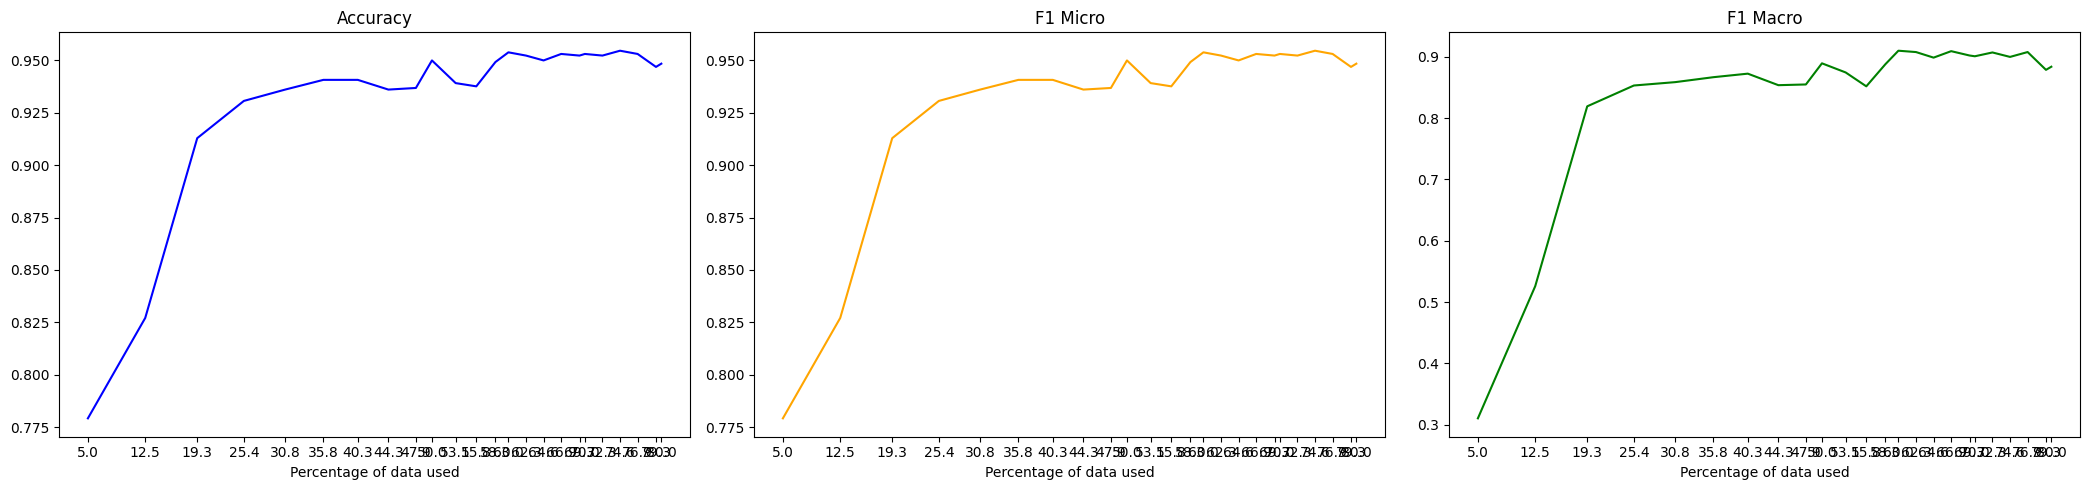

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6029, Accuracy: 0.7879, F1 Micro: 0.8776, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5146, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4672, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4408, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3966, Accuracy: 0.8043, F1 Micro: 0.8894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.352, Accuracy: 0.8385, F1 Micro: 0.9069, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3211, Accuracy: 0.8601, F1 Micro: 0.9177, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2875, Accuracy: 0.878, F1 Micro: 0.9269, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6244, Accuracy: 0.699, F1 Micro: 0.699, F1 Macro: 0.4114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5385, Accuracy: 0.699, F1 Micro: 0.699, F1 Macro: 0.4114
Epoch 3/10, Train Loss: 0.4988, Accuracy: 0.6939, F1 Micro: 0.6939, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.408, Accuracy: 0.7959, F1 Micro: 0.7959, F1 Macro: 0.6916
Epoch 5/10, Train Loss: 0.3849, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2682, Accuracy: 0.8265, F1 Micro: 0.8265, F1 Macro: 0.7827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1822, Accuracy: 0.8367, F1 Micro: 0.8367, F1 Macro: 0.788
Epoch 8/10, Train Loss: 0.1358, Accuracy: 0.8214, F1 Micro: 0.8214, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1305, Accuracy: 0.8673, F1 Micro: 0.8673, F1 Macro: 0.8492
Epoch 10/10, Train Loss: 0.1622, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5942, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4968, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4547, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4285, Accuracy: 0.8065, F1 Micro: 0.8906, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3843, Accuracy: 0.8743, F1 Micro: 0.9249, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2997, Accuracy: 0.8996, F1 Micro: 0.9382, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2588, Accuracy: 0.9092, F1 Micro: 0.9439, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2368, Accuracy: 0.9226, F1 Micro: 0.9519, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5852, Accuracy: 0.7061, F1 Micro: 0.7061, F1 Macro: 0.4139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4932, Accuracy: 0.7469, F1 Micro: 0.7469, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3601, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.8489
Epoch 4/10, Train Loss: 0.2087, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9161
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9092
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.9024
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9067
Epoch 10/10, Train Loss: 0.0182, Accuracy: 0.9224, F1 Micro: 0.9224, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5907, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5136, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4537, Accuracy: 0.8214, F1 Micro: 0.8983, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3794, Accuracy: 0.8891, F1 Micro: 0.9329, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3, Accuracy: 0.9167, F1 Micro: 0.9488, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2476, Accuracy: 0.9278, F1 Micro: 0.9554, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2015, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1707, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9608
Epoch 9/10, Train Loss: 0.1344, Accuracy: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.7047, F1 Micro: 0.7047, F1 Macro: 0.4134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4106, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.261, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9023
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9051
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9098
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.585, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4994, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4285, Accuracy: 0.881, F1 Micro: 0.929, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3204, Accuracy: 0.9055, F1 Micro: 0.9414, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2745, Accuracy: 0.9278, F1 Micro: 0.9551, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2108, Accuracy: 0.9301, F1 Micro: 0.9563, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.9442, F1 Micro: 0.9653, F1 Macro: 0.9633
Epoch 8/10, Train Loss: 0.1469, Accuracy: 0.9442, F1 Micro: 0.9647, F1 Macro: 0.9623
Epoch 9/10, Train Loss: 0.1233, Accuracy: 0.9427, F1 Micro: 0.964, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.7017, F1 Micro: 0.7017, F1 Macro: 0.4123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3969, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8952
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9231
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9079
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8996
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8894
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5624, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4846, Accuracy: 0.8036, F1 Micro: 0.8893, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3886, Accuracy: 0.9122, F1 Micro: 0.9458, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2815, Accuracy: 0.9226, F1 Micro: 0.952, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2289, Accuracy: 0.9308, F1 Micro: 0.9568, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9442, F1 Micro: 0.9648, F1 Macro: 0.9615
Epoch 8/10, Train Loss: 0.1236, Accuracy: 0.9397, F1 Micro: 0.9621, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1052, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5088, Accuracy: 0.7117, F1 Micro: 0.7117, F1 Macro: 0.4158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3404, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9343, F1 Micro: 0.9343, F1 Macro: 0.9187
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9068
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9307, F1 Micro: 0.9307, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9343, F1 Micro: 0.9343, F1 Macro: 0.9206
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9307, F1 Micro: 0.9307, F1 Macro: 0.9109
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9197, F1 Micro: 0.9197, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5733, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.475, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3705, Accuracy: 0.907, F1 Micro: 0.9427, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2716, Accuracy: 0.9293, F1 Micro: 0.9558, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2094, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9635
Epoch 6/10, Train Loss: 0.1611, Accuracy: 0.942, F1 Micro: 0.9634, F1 Macro: 0.9599
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9442, F1 Micro: 0.965, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.6789, F1 Micro: 0.6789, F1 Macro: 0.4044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3365, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.908
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9205
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9172
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5643, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4723, Accuracy: 0.8155, F1 Micro: 0.8954, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3629, Accuracy: 0.9107, F1 Micro: 0.9454, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2485, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2054, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9675
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9472, F1 Micro: 0.9666, F1 Macro: 0.9635
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.6988, F1 Micro: 0.6988, F1 Macro: 0.4114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3367, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9124
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9299
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.918
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9174
Epoch 10/10, Train Loss: 0.0664, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5471, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4425, Accuracy: 0.869, F1 Micro: 0.9231, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3271, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9681
Epoch 6/10, Train Loss: 0.1451, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9501, F1 Micro: 0.9685, F1 Macro: 0.9656
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9687
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.6898, F1 Micro: 0.6898, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3138, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9297
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9347, F1 Micro: 0.9347, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0916, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9332
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.935
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9432
Epoch 10/10, Train Loss: 0.0589, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5463, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4618, Accuracy: 0.8609, F1 Micro: 0.9189, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3242, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.237, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1791, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9686
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9718
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.7308, F1 Micro: 0.7308, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.933
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9209
Epoch 4/10, Train Loss: 0.1095, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9347
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9509
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9411
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9423
Epoch 10/10, Train Loss: 0.0573, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9384

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4437, Accuracy: 0.872, F1 Micro: 0.9248, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3143, Accuracy: 0.9301, F1 Micro: 0.957, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.7731, F1 Micro: 0.7731, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9472
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8795
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0852, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9469
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9372
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9434
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9437
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.943
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9427

Sentiment analysis accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5552, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4259, Accuracy: 0.8958, F1 Micro: 0.9369, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3105, Accuracy: 0.9353, F1 Micro: 0.9597, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9403
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9298
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9545
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9451
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9683, F1 Micro: 0.9683, F1 Macro: 0.9636
Epoch 10/10, Train Loss: 0.0662, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9507

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5472, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4029, Accuracy: 0.9152, F1 Micro: 0.9481, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5846, Accuracy: 0.6721, F1 Micro: 0.6721, F1 Macro: 0.4019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3316, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9286
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9496
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9595, F1 Micro: 0.9595, F1 Macro: 0.9549
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9329
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9329
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415
Epoch 10/10, Train Loss: 0.0682, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9459

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5484, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4202, Accuracy: 0.9182, F1 Micro: 0.9498, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.269, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5577, Accuracy: 0.7031, F1 Micro: 0.7031, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9384
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9648, F1 Micro: 0.9648, F1 Macro: 0.9595
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9688, F1 Micro: 0.9688, F1 Macro: 0.9643
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9609, F1 Micro: 0.9609, F1 Macro: 0.9557
Epoch 10/10, Train Loss: 0.0608, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3873, Accuracy: 0.9241, F1 Micro: 0.9533, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5047, Accuracy: 0.852, F1 Micro: 0.852, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.964, F1 Micro: 0.964, F1 Macro: 0.9598
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9288
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9505
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9452
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9508
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.9499

Sentiment analysis accuracy: 0.964, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4115, Accuracy: 0.91, F1 Micro: 0.9439, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2693, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9708
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.9643, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4944, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9514
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9462
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9688, F1 Micro: 0.9688, F1 Macro: 0.9648
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9478
Epoch 9/10, Train Loss: 0.1095, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8987
Epoch 10/10, Train Loss: 0.0666, Accuracy: 0.9609, F1 Micro: 0.9609, F1 Macro: 0.9562

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5216, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3846, Accuracy: 0.9174, F1 Micro: 0.9484, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9681
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9472, F1 Micro: 0.9667, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9791
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.9695, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5375, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9479
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9654, F1 Micro: 0.9654, F1 Macro: 0.961
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9485
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9479
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9692

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5251, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3716, Accuracy: 0.9211, F1 Micro: 0.9509, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9722
Epoch 10/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5418, Accuracy: 0.8294, F1 Micro: 0.8294, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9556
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9643, F1 Micro: 0.9643, F1 Macro: 0.9602
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9643, F1 Micro: 0.9643, F1 Macro: 0.9602
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 10/10, Train Loss: 0.072, Accuracy: 0.9206, F1 Micro: 0.9206, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3921, Accuracy: 0.9204, F1 Micro: 0.9505, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2519, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9754
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9479
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Epoch 10/10, Train Loss: 0.0532, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3784, Accuracy: 0.9249, F1 Micro: 0.9533, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2394, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4685, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9223
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9067
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9354, F1 Micro: 0.9354, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3752, Accuracy: 0.9301, F1 Micro: 0.9565, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9801
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9807
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4691, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9334
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9271
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9172
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9445
Epoch 10/10, Train Loss: 0.064, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5259, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3765, Accuracy: 0.9182, F1 Micro: 0.9495, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.8431, F1 Micro: 0.8431, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9425
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9261
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.929
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9428
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5155, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3731, Accuracy: 0.933, F1 Micro: 0.9586, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2392, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9458
Epoch 5/10, Train Loss: 0.0922, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9338
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9295
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9107
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9408
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9367
Epoch 10/10, Train Loss: 0.0672, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9065

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5169, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3743, Accuracy: 0.9301, F1 Micro: 0.9566, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9806
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5076, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9295
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9272
Epoch 5/10, Train Loss: 0.105, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9186
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 10/10, Train Loss: 0.0543, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9272

Sentiment analysis accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
              pr

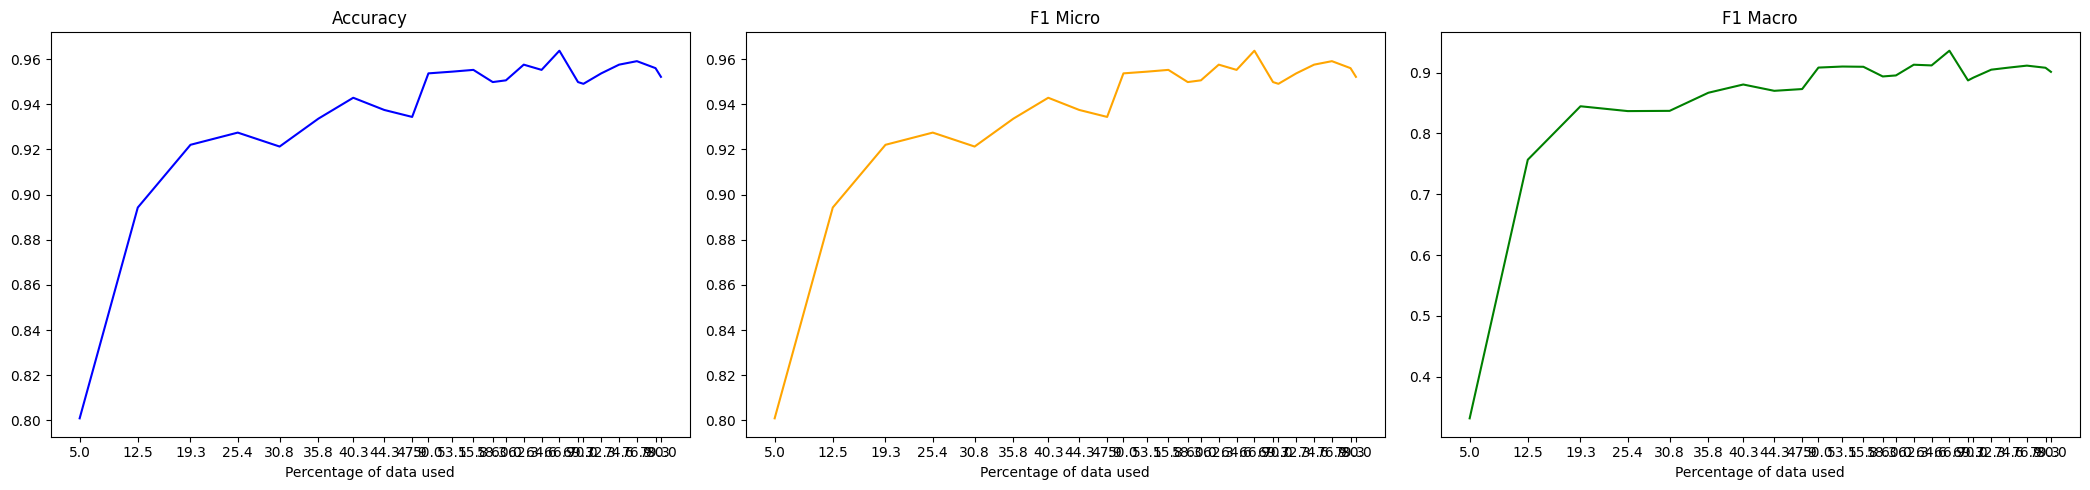

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6149, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4882, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4616, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4332, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3996, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3659, Accuracy: 0.8118, F1 Micro: 0.8929, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3336, Accuracy: 0.8318, F1 Micro: 0.9024, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2783, Accuracy: 0.8497, F1 Micro: 0.9119, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6099, Accuracy: 0.6892, F1 Micro: 0.6892, F1 Macro: 0.408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5392, Accuracy: 0.6892, F1 Micro: 0.6892, F1 Macro: 0.408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4547, Accuracy: 0.7095, F1 Micro: 0.7095, F1 Macro: 0.4907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2938, Accuracy: 0.7365, F1 Micro: 0.7365, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2798, Accuracy: 0.8378, F1 Micro: 0.8378, F1 Macro: 0.7838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1991, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.823
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.8378, F1 Micro: 0.8378, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.8378, F1 Micro: 0.8378, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8697
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5743, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4729, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4472, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4072, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3768, Accuracy: 0.8222, F1 Micro: 0.8988, F1 Macro: 0.8978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3138, Accuracy: 0.8571, F1 Micro: 0.9167, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2777, Accuracy: 0.8921, F1 Micro: 0.9357, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2191, Accuracy: 0.9092, F1 Micro: 0.9454, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6531, Accuracy: 0.6683, F1 Micro: 0.6683, F1 Macro: 0.4006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5028, Accuracy: 0.8146, F1 Micro: 0.8146, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.367, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2507, Accuracy: 0.878, F1 Micro: 0.878, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8908
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.8488, F1 Micro: 0.8488, F1 Macro: 0.8085
Epoch 8/10, Train Loss: 0.0279, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8865
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5796, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5014, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4438, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3758, Accuracy: 0.8445, F1 Micro: 0.9101, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3077, Accuracy: 0.875, F1 Micro: 0.9264, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2576, Accuracy: 0.9234, F1 Micro: 0.9535, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2011, Accuracy: 0.942, F1 Micro: 0.9643, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1844, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.965
Epoch 9/10, Train Loss: 0.1399, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6163, Accuracy: 0.6622, F1 Micro: 0.6622, F1 Macro: 0.3984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4797, Accuracy: 0.8514, F1 Micro: 0.8514, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2657, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9279, F1 Micro: 0.9279, F1 Macro: 0.9184
Epoch 5/10, Train Loss: 0.074, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0323, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9388
Epoch 7/10, Train Loss: 0.0345, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9396
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9172
Epoch 10/10, Train Loss: 0.0554, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5664, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5078, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4449, Accuracy: 0.8259, F1 Micro: 0.9007, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3497, Accuracy: 0.8936, F1 Micro: 0.9366, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2699, Accuracy: 0.9397, F1 Micro: 0.963, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2063, Accuracy: 0.9412, F1 Micro: 0.9639, F1 Macro: 0.9626
Epoch 7/10, Train Loss: 0.1685, Accuracy: 0.939, F1 Micro: 0.9624, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1359, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1155, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6225, Accuracy: 0.6486, F1 Micro: 0.6486, F1 Macro: 0.3934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4088, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.9279, F1 Micro: 0.9279, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.089, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.941
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9027
Epoch 6/10, Train Loss: 0.0494, Accuracy: 0.9324, F1 Micro: 0.9324, F1 Macro: 0.928
Epoch 7/10, Train Loss: 0.0375, Accuracy: 0.9324, F1 Micro: 0.9324, F1 Macro: 0.9252
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9363
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8917
Epoch 10/10, Train Loss: 0.0135, Accuracy: 0.9369, F1 Micro: 0.9369, F1 Macro: 0.9295

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4703, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4022, Accuracy: 0.8839, F1 Micro: 0.9313, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3078, Accuracy: 0.9249, F1 Micro: 0.9539, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.222, Accuracy: 0.9368, F1 Micro: 0.9611, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1798, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1389, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.9654
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9644
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.545, Accuracy: 0.7224, F1 Micro: 0.7224, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1342, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9395
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9287
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9084
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.918
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9209
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9121
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0529, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9395

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.565, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4915, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.395, Accuracy: 0.875, F1 Micro: 0.9262, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2916, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2165, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.9656
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1382, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9672
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5292, Accuracy: 0.7098, F1 Micro: 0.7098, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1294, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.101, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9548
Epoch 5/10, Train Loss: 0.0876, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9446
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9393
Epoch 7/10, Train Loss: 0.0449, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9256
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9298
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9181
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4794, Accuracy: 0.8051, F1 Micro: 0.8901, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3923, Accuracy: 0.904, F1 Micro: 0.9424, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2546, Accuracy: 0.9375, F1 Micro: 0.9614, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1938, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9694
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9707
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2166, Accuracy: 0.9595, F1 Micro: 0.9595, F1 Macro: 0.9532
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9496
Epoch 4/10, Train Loss: 0.1053, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9486
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8817
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9595, F1 Micro: 0.9595, F1 Macro: 0.9535
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.949
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8967
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9393

Sentiment analysis accuracy: 0.9595, F1 Micro: 0.959

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5652, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4716, Accuracy: 0.8177, F1 Micro: 0.8965, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.357, Accuracy: 0.9249, F1 Micro: 0.9543, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2419, Accuracy: 0.9472, F1 Micro: 0.9674, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9694
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9706
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.97
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5263, Accuracy: 0.8841, F1 Micro: 0.8841, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9657, F1 Micro: 0.9657, F1 Macro: 0.9612
Epoch 3/10, Train Loss: 0.1291, Accuracy: 0.9571, F1 Micro: 0.9571, F1 Macro: 0.9521
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9402
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9349
Epoch 6/10, Train Loss: 0.0665, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9339
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9657, F1 Micro: 0.9657, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9657, F1 Micro: 0.9657, F1 Macro: 0.9615
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9614, F1 Micro: 0.9614, F1 Macro: 0.9568

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.473, Accuracy: 0.8132, F1 Micro: 0.8942, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3522, Accuracy: 0.9293, F1 Micro: 0.9569, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2385, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1834, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.814, F1 Micro: 0.814, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9485
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9478
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9463, F1 Micro: 0.9463, F1 Macro: 0.9374
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9491
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9143
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9351
Epoch 10/10, Train Loss: 0.066, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5591, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4654, Accuracy: 0.8371, F1 Micro: 0.9062, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3336, Accuracy: 0.9382, F1 Micro: 0.9621, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2257, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5159, Accuracy: 0.8543, F1 Micro: 0.8543, F1 Macro: 0.8078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9463
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9265
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.955
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.91
Epoch 10/10, Train Loss: 0.0861, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5524, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4359, Accuracy: 0.8683, F1 Micro: 0.9225, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3159, Accuracy: 0.9315, F1 Micro: 0.9581, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.214, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9709
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4948, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9387
Epoch 4/10, Train Loss: 0.1165, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9224
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9138
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9016
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9408
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9447, F1 Micro: 0.9447, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5504, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4374, Accuracy: 0.8534, F1 Micro: 0.9148, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3024, Accuracy: 0.9427, F1 Micro: 0.9647, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9591, F1 Micro: 0.9743, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9428
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9507
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9411
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9513
Epoch 10/10, Train Loss: 0.0563, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4392, Accuracy: 0.8839, F1 Micro: 0.9312, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2905, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1999, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.7829, F1 Micro: 0.7829, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9102
Epoch 5/10, Train Loss: 0.1059, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.934
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9224
Epoch 10/10, Train Loss: 0.0605, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5482, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4307, Accuracy: 0.9152, F1 Micro: 0.9483, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2748, Accuracy: 0.9457, F1 Micro: 0.966, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.511, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2091, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9431
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9302
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9379
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9127
Epoch 10/10, Train Loss: 0.0607, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9316

Sentiment analysis accuracy: 0.9484, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.8929, F1 Micro: 0.9352, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2802, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.939
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9271
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9299
Epoch 10/10, Train Loss: 0.053, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4213, Accuracy: 0.9129, F1 Micro: 0.9471, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2708, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5139, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9246
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.114, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9463
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9413
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.943
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9183
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9522, F1 Micro: 0.9522, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4053, Accuracy: 0.9137, F1 Micro: 0.9477, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9688, F1 Micro: 0.9805, F1 Macro: 0.9795
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.965, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4888, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2478, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.947
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9379
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9422
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.947
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9222
Epoch 10/10, Train Loss: 0.074, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4079, Accuracy: 0.9085, F1 Micro: 0.9448, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.968, F1 Micro: 0.9798, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4742, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9172
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8785
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9015
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9002
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8963
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9227
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.9036
Epoch 10/10, Train Loss: 0.0743, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.909

Sentiment analysis accuracy: 0.9316, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.7976, F1 Micro: 0.8863, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.405, Accuracy: 0.9189, F1 Micro: 0.9505, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4983, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9239
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1168, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9311
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9225
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9151
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9127
Epoch 10/10, Train Loss: 0.0664, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8991

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9598, F1 Micro: 0.9751, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.917
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9091
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9004
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9009
Epoch 10/10, Train Loss: 0.078, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5207, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4044, Accuracy: 0.9278, F1 Micro: 0.9558, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9807
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.48, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.924
Epoch 10/10, Train Loss: 0.0599, Accuracy: 0.922

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4007, Accuracy: 0.9256, F1 Micro: 0.9542, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9673, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4788, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9428
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Epoch 4/10, Train Loss: 0.1252, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9524
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9561
Epoch 10/10, Train Loss: 0.0457, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.9293, F1 Micro: 0.9566, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2487, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9723
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9804
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4796, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9381
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9307
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9233
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9296
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9346
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9304
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9381
Epoch 10/10, Train Loss: 0.0553, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335

Sentiment analysis accuracy: 0.9442, F1 Micro: 0.9

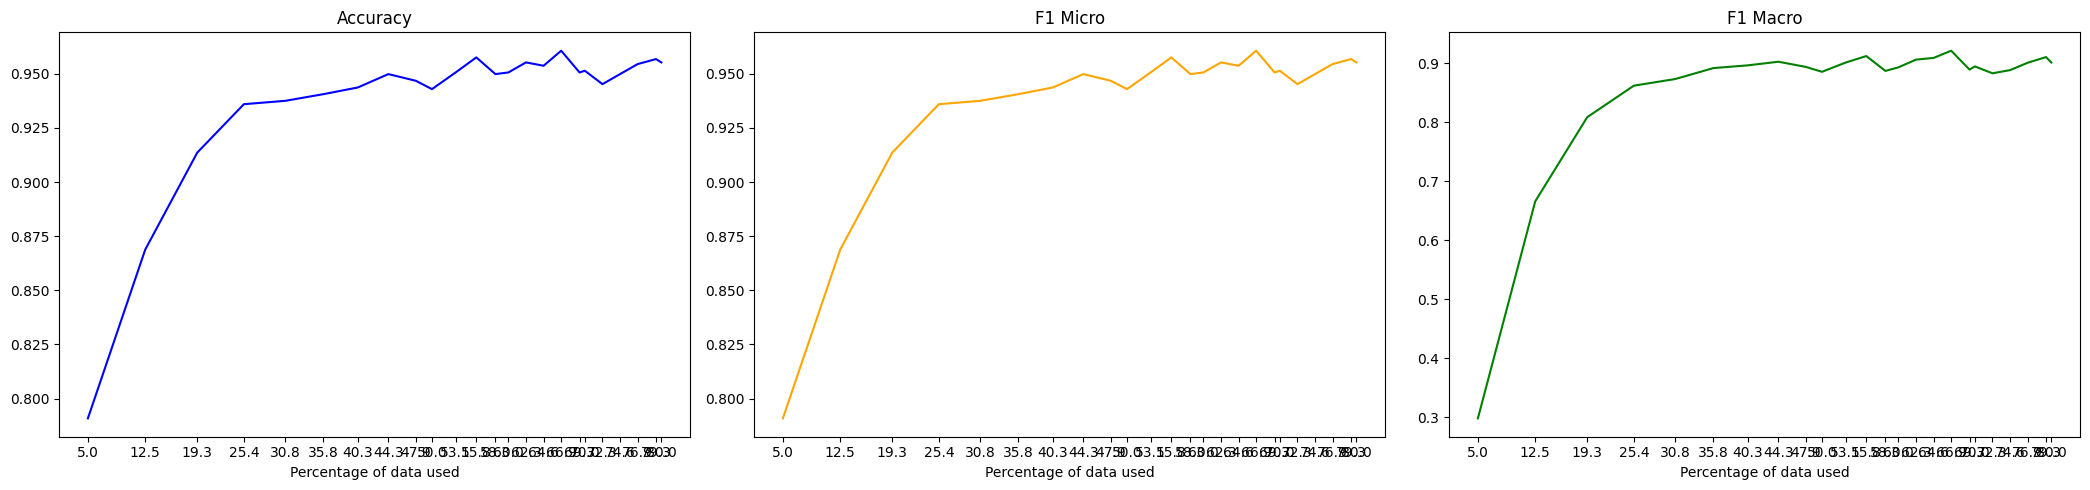

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.578, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.484, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4448, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4382, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3956, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3717, Accuracy: 0.8125, F1 Micro: 0.8935, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.324, Accuracy: 0.8318, F1 Micro: 0.9032, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2794, Accuracy: 0.8564, F1 Micro: 0.9156, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6703, Accuracy: 0.6899, F1 Micro: 0.6899, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.57, Accuracy: 0.7405, F1 Micro: 0.7405, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4981, Accuracy: 0.7911, F1 Micro: 0.7911, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3723, Accuracy: 0.8481, F1 Micro: 0.8481, F1 Macro: 0.8136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2367, Accuracy: 0.8671, F1 Micro: 0.8671, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8987
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5776, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.491, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4803, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 4/10, Train Loss: 0.4329, Accuracy: 0.7879, F1 Micro: 0.8807, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3805, Accuracy: 0.8326, F1 Micro: 0.9026, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8668, F1 Micro: 0.9206, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2809, Accuracy: 0.8973, F1 Micro: 0.9377, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.8996, F1 Micro: 0.9382, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1991, Accuracy: 0.9025, F1 Micro: 0.9395, F1 Macro: 0.9366
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6262, Accuracy: 0.6971, F1 Micro: 0.6971, F1 Macro: 0.4108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5359, Accuracy: 0.7596, F1 Micro: 0.7596, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4082, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9139
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9088
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9097
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9327, F1 Micro: 0.9327, F1 Macro: 0.9235
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5582, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5117, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4586, Accuracy: 0.7946, F1 Micro: 0.8841, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4089, Accuracy: 0.8289, F1 Micro: 0.9011, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3315, Accuracy: 0.878, F1 Micro: 0.9263, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2763, Accuracy: 0.8951, F1 Micro: 0.9362, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2133, Accuracy: 0.9018, F1 Micro: 0.9393, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1761, Accuracy: 0.91, F1 Micro: 0.9441, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1411, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5989, Accuracy: 0.7339, F1 Micro: 0.7339, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4484, Accuracy: 0.8283, F1 Micro: 0.8283, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.8798, F1 Micro: 0.8798, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9227, F1 Micro: 0.9227, F1 Macro: 0.9057
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9142, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5714, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.4919, Accuracy: 0.7879, F1 Micro: 0.8812, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4599, Accuracy: 0.8043, F1 Micro: 0.8878, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3778, Accuracy: 0.8653, F1 Micro: 0.9196, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2961, Accuracy: 0.901, F1 Micro: 0.9395, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.235, Accuracy: 0.9085, F1 Micro: 0.9429, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1804, Accuracy: 0.9211, F1 Micro: 0.951, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1465, Accuracy: 0.9323, F1 Micro: 0.9578, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1349, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5541, Accuracy: 0.7191, F1 Micro: 0.7191, F1 Macro: 0.4183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.378, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9085
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8947
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9038
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8937
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8991
Epoch 10/10, Train Loss: 0.0594, Accuracy: 0.9139, F1 Micro: 0.9139, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5676, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5001, Accuracy: 0.7917, F1 Micro: 0.8826, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4244, Accuracy: 0.8571, F1 Micro: 0.9157, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3249, Accuracy: 0.8981, F1 Micro: 0.9383, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2469, Accuracy: 0.9271, F1 Micro: 0.9546, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1922, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9442, F1 Micro: 0.9648, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1211, Accuracy: 0.9457, F1 Micro: 0.9659, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1002, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.7043, F1 Micro: 0.7043, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3368, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.905
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9116
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.908
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 2/10, Train Loss: 0.4901, Accuracy: 0.7924, F1 Micro: 0.8816, F1 Macro: 0.8786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4252, Accuracy: 0.8638, F1 Micro: 0.9184, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3152, Accuracy: 0.9167, F1 Micro: 0.9488, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.23, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1685, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1471, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9659
Epoch 9/10, Train Loss: 0.0937, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9664
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4997, Accuracy: 0.6923, F1 Micro: 0.6923, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9442
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9325
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9234
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9304
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9349
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9125
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9397

Sentiment analysis accuracy: 0.9514, F1 Micro: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.556, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.497, Accuracy: 0.7946, F1 Micro: 0.8841, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8906, F1 Micro: 0.9335, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3072, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2189, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1709, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.939, F1 Micro: 0.9616, F1 Macro: 0.9584
Epoch 8/10, Train Loss: 0.1085, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.56, Accuracy: 0.6802, F1 Micro: 0.6802, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3197, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9408
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9138
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9322
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9295
Epoch 10/10, Train Loss: 0.0586, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5601, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.5006, Accuracy: 0.7872, F1 Micro: 0.878, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3863, Accuracy: 0.8943, F1 Micro: 0.9364, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2605, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1784, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9686
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9674
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9683
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5052, Accuracy: 0.7214, F1 Micro: 0.7214, F1 Macro: 0.5146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3088, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9267
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9345
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8896
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5505, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.485, Accuracy: 0.814, F1 Micro: 0.8932, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3739, Accuracy: 0.9122, F1 Micro: 0.9468, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2572, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1818, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9685
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0797, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4985, Accuracy: 0.749, F1 Micro: 0.749, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9265
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1327, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9353
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9349
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5352, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4669, Accuracy: 0.8356, F1 Micro: 0.9045, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3523, Accuracy: 0.9167, F1 Micro: 0.9492, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2365, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9686
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9487, F1 Micro: 0.9676, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.6939, F1 Micro: 0.6939, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3123, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9236
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0821, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9151
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9388, F1 Micro: 0.9388, F1 Macro: 0.9319
Epoch 10/10, Train Loss: 0.0538, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4663, Accuracy: 0.8177, F1 Micro: 0.8946, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3369, Accuracy: 0.9315, F1 Micro: 0.958, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2297, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.9689
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5028, Accuracy: 0.7059, F1 Micro: 0.7059, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2822, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9367
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9046
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9298
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9076
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9206
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9056
Epoch 10/10, Train Loss: 0.0619, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9164

Sentiment analysis accuracy: 0.9451, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4649, Accuracy: 0.8512, F1 Micro: 0.9115, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3218, Accuracy: 0.9353, F1 Micro: 0.9595, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2119, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9719
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9684
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9576, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5204, Accuracy: 0.75, F1 Micro: 0.75, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9501
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1157, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9497
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9381
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.945
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9374
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9503
Epoch 10/10, Train Loss: 0.081, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9199

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5397, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4521, Accuracy: 0.8661, F1 Micro: 0.9195, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3004, Accuracy: 0.9397, F1 Micro: 0.963, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2043, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9676
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9427, F1 Micro: 0.9638, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9698
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Epoch 10/10, Train Loss: 0.0538, Accuracy: 0.9554, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.776, F1 Micro: 0.776, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9317
Epoch 4/10, Train Loss: 0.1124, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9369
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9245
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9245
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412

Sentim

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.8586, F1 Micro: 0.9156, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3048, Accuracy: 0.9345, F1 Micro: 0.9591, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9708
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.504, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9137
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9298
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9551
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9371
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5344, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4444, Accuracy: 0.8765, F1 Micro: 0.9261, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5088, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9471
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9345
Epoch 4/10, Train Loss: 0.124, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9281
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9124
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9341
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9383

Sentiment analysis accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9471
              p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4216, Accuracy: 0.8891, F1 Micro: 0.9335, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2692, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9681
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2071, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9482
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9479
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9287
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9287
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9437
Epoch 10/10, Train Loss: 0.0551, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4232, Accuracy: 0.8884, F1 Micro: 0.933, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2717, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9682
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9217
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9258
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.923
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.916
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9104

Sentiment analysis accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
             

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.7894, F1 Micro: 0.8818, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4274, Accuracy: 0.8914, F1 Micro: 0.9346, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2752, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.972
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5141, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2803, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9417
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9276
Epoch 4/10, Train Loss: 0.1256, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9126
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9284
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9319
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9284
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.92
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9162
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9208

Sentiment analysis accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9417
            

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5228, Accuracy: 0.7946, F1 Micro: 0.8837, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.9085, F1 Micro: 0.9447, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2543, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5062, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9266
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9282
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0.9459, F1 Micro: 0.9459, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7917, F1 Micro: 0.8829, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4177, Accuracy: 0.9152, F1 Micro: 0.9481, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9806
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.531, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9434
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9105
Epoch 10/10, Train Loss: 0.0723, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4158, Accuracy: 0.9085, F1 Micro: 0.9442, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2593, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4831, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1434, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1071, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9174
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9271
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9087
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9165
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9368, F1 Micro: 0.9368, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7969, F1 Micro: 0.8851, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4042, Accuracy: 0.9182, F1 Micro: 0.9495, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9781
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4816, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9343, F1 Micro: 0.9343, F1 Macro: 0.9271
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9345
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9322
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9378
Epoch 10/10, Train Loss: 0.0563, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.416, Accuracy: 0.9062, F1 Micro: 0.9424, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4731, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9162
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9484
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9158
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9312
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9238
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9432
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9059

Sentiment analysis accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9484
           

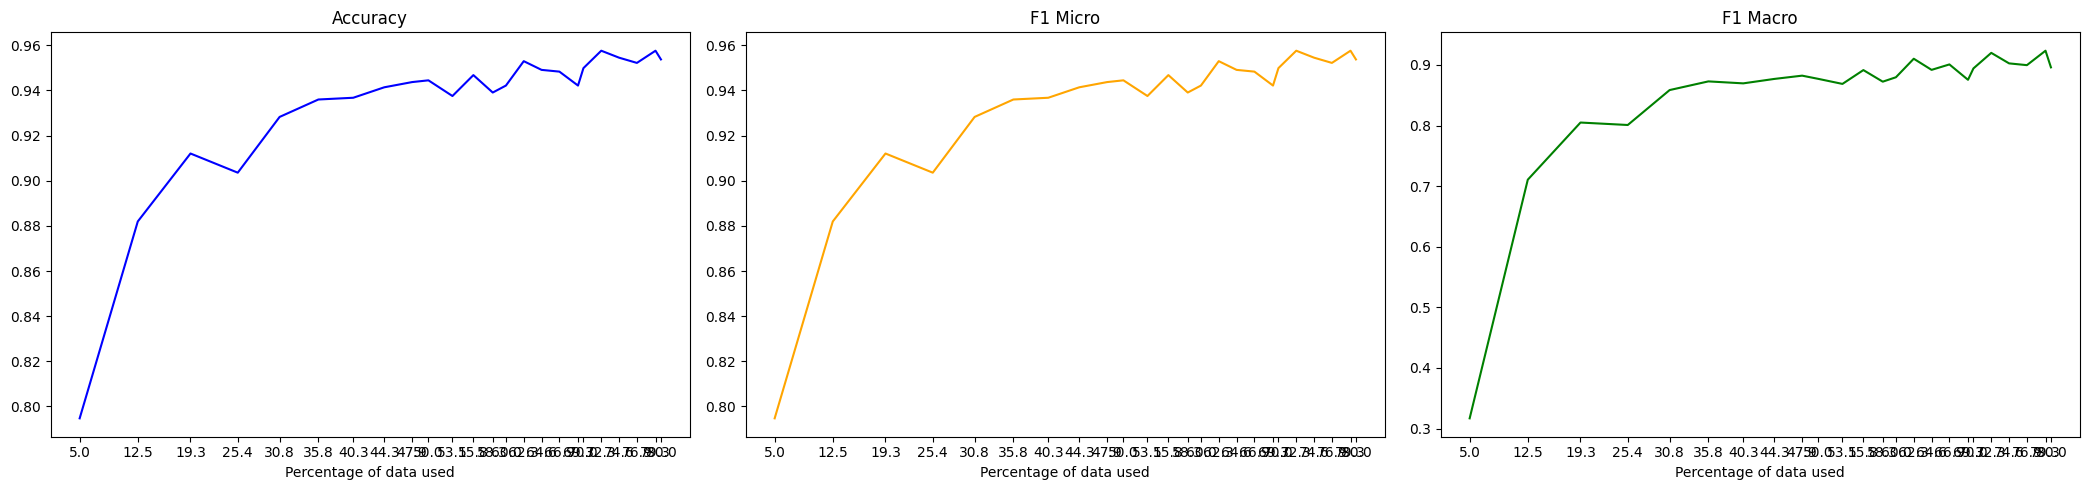

In [26]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6061, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.504, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4681, Accuracy: 0.7946, F1 Micro: 0.8845, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4473, Accuracy: 0.8013, F1 Micro: 0.8874, F1 Macro: 0.8855
Epoch 5/10, Train Loss: 0.4142, Accuracy: 0.8036, F1 Micro: 0.8865, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3902, Accuracy: 0.8147, F1 Micro: 0.8935, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3797, Accuracy: 0.8229, F1 Micro: 0.897, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3154, Accuracy: 0.8289, F1 Micro: 0.899, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2827, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6126, Accuracy: 0.7643, F1 Micro: 0.7643, F1 Macro: 0.4332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4259, Accuracy: 0.7643, F1 Micro: 0.7643, F1 Macro: 0.4332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3753, Accuracy: 0.7643, F1 Micro: 0.7643, F1 Macro: 0.4332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3571, Accuracy: 0.7929, F1 Micro: 0.7929, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2751, Accuracy: 0.8286, F1 Micro: 0.8286, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1757, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.7825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1584, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8528
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6004, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5348, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5203, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4748, Accuracy: 0.8088, F1 Micro: 0.8918, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4126, Accuracy: 0.817, F1 Micro: 0.8953, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3759, Accuracy: 0.8534, F1 Micro: 0.914, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.316, Accuracy: 0.8765, F1 Micro: 0.9256, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2533, Accuracy: 0.901, F1 Micro: 0.94, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4197, Accuracy: 0.7137, F1 Micro: 0.7137, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2603, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1021, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9028
Epoch 6/10, Train Loss: 0.0499, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.909
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8787
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5744, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5195, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4822, Accuracy: 0.7946, F1 Micro: 0.8834, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4434, Accuracy: 0.8274, F1 Micro: 0.9005, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3643, Accuracy: 0.8668, F1 Micro: 0.9209, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2907, Accuracy: 0.9003, F1 Micro: 0.9393, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2273, Accuracy: 0.9167, F1 Micro: 0.949, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1877, Accuracy: 0.9196, F1 Micro: 0.9505, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.7149, F1 Micro: 0.7149, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3413, Accuracy: 0.7562, F1 Micro: 0.7562, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1152, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.9034
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8868
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8738
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8913
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8974
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8974

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5772, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.517, Accuracy: 0.7991, F1 Micro: 0.8869, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4818, Accuracy: 0.8222, F1 Micro: 0.8983, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3816, Accuracy: 0.8743, F1 Micro: 0.9249, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.297, Accuracy: 0.907, F1 Micro: 0.9427, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2267, Accuracy: 0.9256, F1 Micro: 0.9543, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1734, Accuracy: 0.9353, F1 Micro: 0.9601, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1417, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4529, Accuracy: 0.7113, F1 Micro: 0.7113, F1 Macro: 0.4156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8926
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0567, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9075
Epoch 5/10, Train Loss: 0.1004, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8911
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9456, F1 Micro: 0.9456, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.028, Accuracy: 0.9456, F1 Micro: 0.9456, F1 Macro: 0.9346
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9293
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9414, F1 Micro: 0.9414, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.559, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4935, Accuracy: 0.8013, F1 Micro: 0.888, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4262, Accuracy: 0.8624, F1 Micro: 0.9191, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3226, Accuracy: 0.91, F1 Micro: 0.9453, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2379, Accuracy: 0.9278, F1 Micro: 0.9556, F1 Macro: 0.954
Epoch 6/10, Train Loss: 0.1725, Accuracy: 0.9286, F1 Micro: 0.9555, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9345, F1 Micro: 0.959, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.9412, F1 Micro: 0.9629, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.6917, F1 Micro: 0.6917, F1 Macro: 0.4089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9151
Epoch 4/10, Train Loss: 0.0997, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8987
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9265
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9292, F1 Micro: 0.9292, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9295
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4903, Accuracy: 0.8013, F1 Micro: 0.8881, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.408, Accuracy: 0.8698, F1 Micro: 0.9233, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2946, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2254, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9679
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.51, Accuracy: 0.6885, F1 Micro: 0.6885, F1 Macro: 0.4078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Epoch 3/10, Train Loss: 0.1086, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9127
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0708, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9377
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9426, F1 Micro: 0.9426, F1 Macro: 0.9345
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9291
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9179
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9173

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5577, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4873, Accuracy: 0.8103, F1 Micro: 0.892, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3889, Accuracy: 0.8981, F1 Micro: 0.9388, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2792, Accuracy: 0.939, F1 Micro: 0.9621, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2073, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9664
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4937, Accuracy: 0.7149, F1 Micro: 0.7149, F1 Macro: 0.4766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.936
Epoch 3/10, Train Loss: 0.1236, Accuracy: 0.9277, F1 Micro: 0.9277, F1 Macro: 0.9187
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.9096
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9307
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9225
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9173
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9391
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9287

Sentiment analysis accuracy: 0.9478, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.551, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4711, Accuracy: 0.8222, F1 Micro: 0.8985, F1 Macro: 0.8972
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.9249, F1 Micro: 0.9538, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2376, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.489, Accuracy: 0.7863, F1 Micro: 0.7863, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9417
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.928
Epoch 4/10, Train Loss: 0.1154, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9262
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9295
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9375
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.937
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9413
Epoch 10/10, Train Loss: 0.0595, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.899

Sentiment analysis accuracy: 0.9504, F1 Micro: 0.9504

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5532, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4746, Accuracy: 0.8155, F1 Micro: 0.8949, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.9219, F1 Micro: 0.9526, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2323, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9642
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9675
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5033, Accuracy: 0.8038, F1 Micro: 0.8038, F1 Macro: 0.7094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9043
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9205
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9139
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9082
Epoch 9/10, Train Loss: 0.1063, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9047
Epoch 10/10, Train Loss: 0.0737, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4613, Accuracy: 0.8318, F1 Micro: 0.9035, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3426, Accuracy: 0.9263, F1 Micro: 0.9548, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.233, Accuracy: 0.9442, F1 Micro: 0.9656, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9715
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.958

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4998, Accuracy: 0.8521, F1 Micro: 0.8521, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9259
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9416
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9153
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.91
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9512
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4646, Accuracy: 0.8348, F1 Micro: 0.905, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3072, Accuracy: 0.936, F1 Micro: 0.9607, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9673
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1267, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9276
Epoch 4/10, Train Loss: 0.1093, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9206
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9349
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9507
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9358
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9373, F1 Micro: 0.9373, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.447, Accuracy: 0.8653, F1 Micro: 0.9209, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3019, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9688
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.962
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.7171, F1 Micro: 0.7171, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2673, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9413
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8996
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9276
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.912
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9195
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9327
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.928
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9319

Sentiment analysis accuracy: 0.9482, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8802, F1 Micro: 0.9287, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2778, Accuracy: 0.942, F1 Micro: 0.9643, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9711
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9487, F1 Micro: 0.9678, F1 Macro: 0.9651
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9524, F1 Micro: 0.9699, F1 Macro: 0.9672
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.9635, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.7346, F1 Micro: 0.7346, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9476
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.9025
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9476
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4395, Accuracy: 0.8884, F1 Micro: 0.9332, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2791, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0579, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5112, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9213
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9268
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4315, Accuracy: 0.8929, F1 Micro: 0.9359, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9674
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5127, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9294
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8895
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9095
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9112
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9169
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9156
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9215
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9089

Sentiment analysis accuracy: 0.9373, F1 Micro: 0.937

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4109, Accuracy: 0.9085, F1 Micro: 0.9446, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2695, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.0461, Accuracy: 0.9613, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4776, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Epoch 3/10, Train Loss: 0.1283, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1037, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9468
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9508
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9422
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9062
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9411
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8863

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.9159, F1 Micro: 0.9489, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9561, F1 Micro: 0.9721, F1 Macro: 0.9698
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9583, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5336, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.9503
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9217
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9217
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9174
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9217
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9384
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9377
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9292

Sentiment analysis accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.9503
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4015, Accuracy: 0.9211, F1 Micro: 0.9519, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2675, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9727
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9554, F1 Micro: 0.9716, F1 Macro: 0.9688
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9613, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9407
Epoch 5/10, Train Loss: 0.1006, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9237
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9392
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9323
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9312
Epoch 10/10, Train Loss: 0.0562, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4237, Accuracy: 0.9048, F1 Micro: 0.9424, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9735
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9576, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4618, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9262
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9133
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9108
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9049
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9164
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9076
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9421
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9379
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9164

Sentiment analysis accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9421
          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5263, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.9182, F1 Micro: 0.9503, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9509, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9598, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2063, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9582, F1 Micro: 0.9582, F1 Macro: 0.9517
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.944
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.962, F1 Micro: 0.962, F1 Macro: 0.956
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.938

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4083, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2499, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4903, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9208
Epoch 4/10, Train Loss: 0.1167, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.94
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9306

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5275, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4102, Accuracy: 0.9308, F1 Micro: 0.9576, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4802, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9481
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9285
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9118
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9471
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9118
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9198
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9351, F1 Micro: 0.9351, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.409, Accuracy: 0.9204, F1 Micro: 0.9514, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4934, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.962, F1 Micro: 0.962, F1 Macro: 0.9571
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9433
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9582, F1 Micro: 0.9582, F1 Macro: 0.9529
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Epoch 10/10, Train Loss: 0.0676, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9168

Sentiment analysis accuracy: 0.962, F1 Micro: 0.962, F1 Macro: 0.9571
              precis

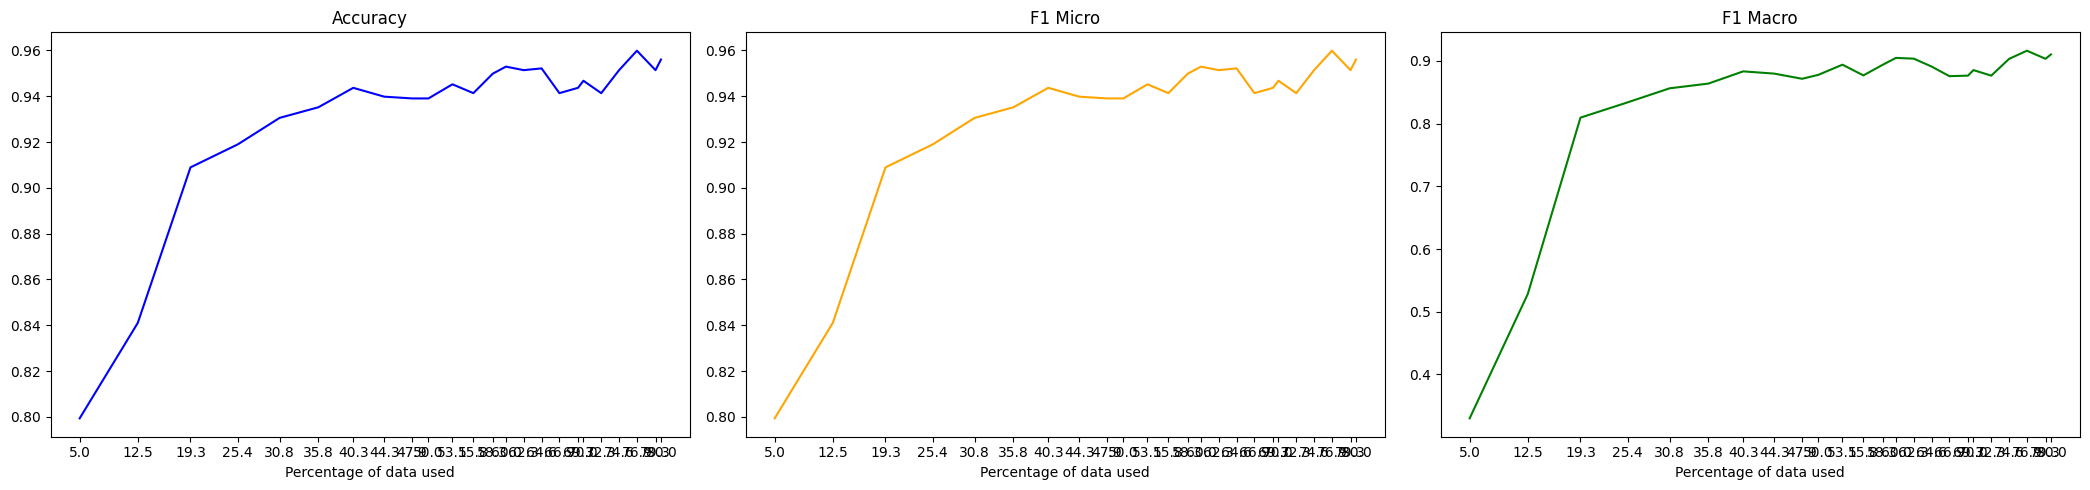

In [27]:
active_learning(seeds[4], 4)